# Modelo de aprendizaje no supervisado: K-Means
Por: Andrea Rodriguez Ospina

---
---

## Análisis exploratorio de datos 

Se importan las librerías y se cargan los datos

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import warnings

In [26]:
#Se carga el dataset
ruta_archivo = r'D:\Estudios\UNAD\Análisis de datos\Guias\Tarea 4 - Algoritmos de Aprendizaje no supe\Anexo 5 - Dataset Mall Customer Segmentation\Mall_Customers.csv'
datos = pd.read_csv(ruta_archivo)

In [27]:
# Muestra las primeras filas del dataframe
print(datos.head())

# Obtieneinformación sobre los tipos de datos y valores faltantes
print(datos.info())

# Resumen estadístico de las variables numéricas
print(datos.describe())

# Verifica la presencia de valores faltantes
print(datos.isnull().sum())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  

## Relación entre variables

La siguiente matriz de correlación muestra las correlaciones entre todas las variables en forma de un mapa de calor, donde los valores más cercanos a 1 indican una correlación positiva fuerte, los valores cercanos a -1 indican una correlación negativa fuerte, y los valores cercanos a 0 indican una correlación débil o nula. 

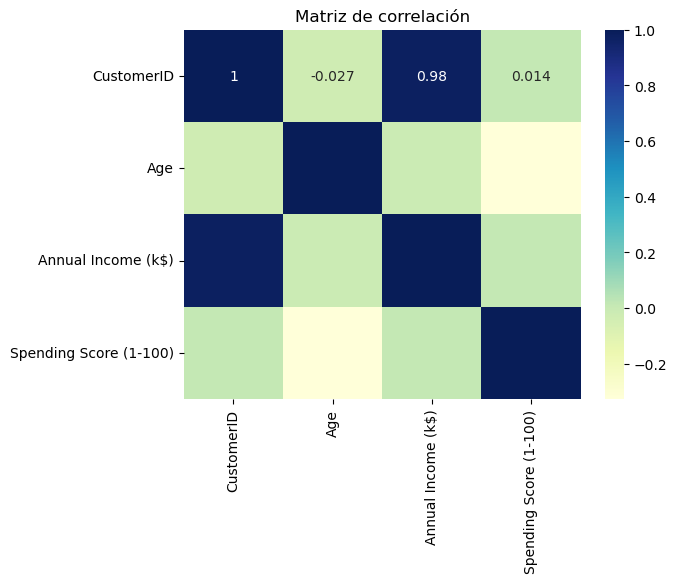

In [28]:
# Excluir columnas no numéricas de la matriz de correlación
columnas_numericas = datos.select_dtypes(include=[np.number]).columns
correlation_matrix = datos[columnas_numericas].corr()

# Mostrar la matriz de correlación como un mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Matriz de correlación')
plt.show()

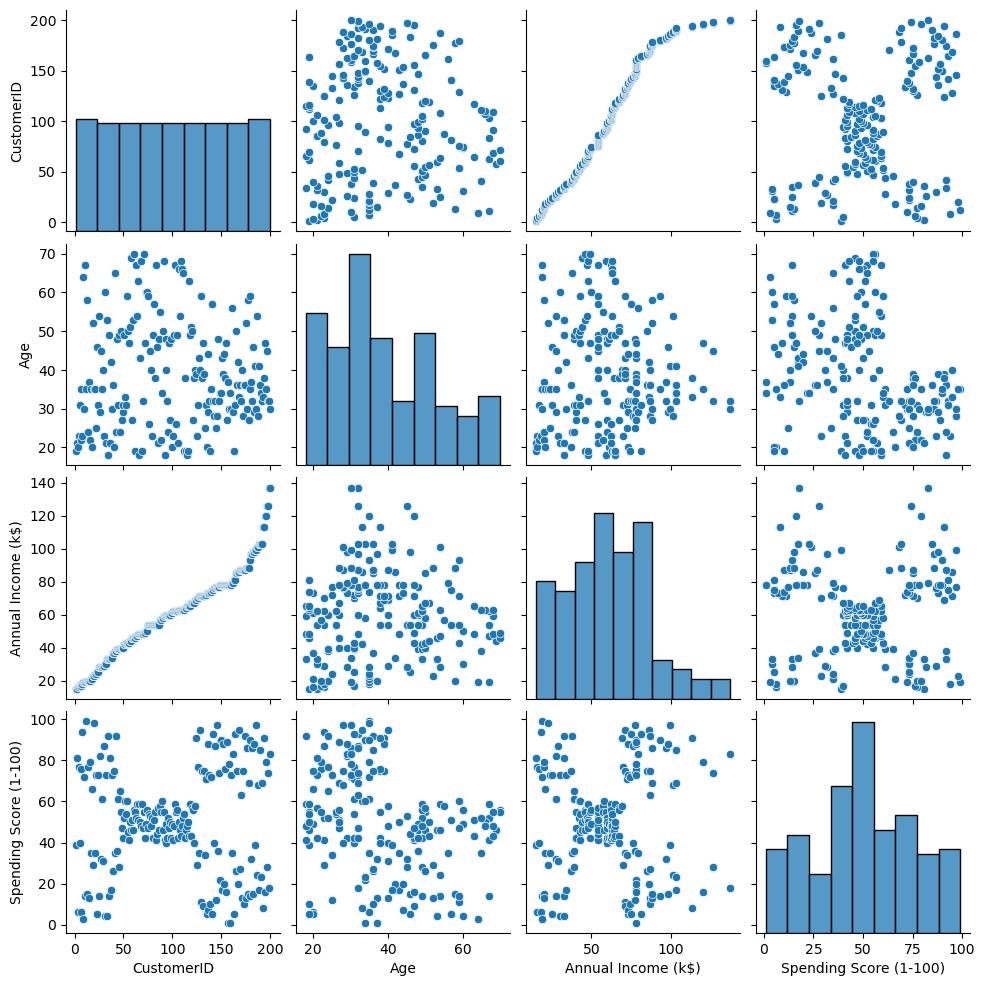

In [29]:
# Separate numeric columns
datos_numericos = datos.select_dtypes(include=[np.number])

# Convertir valores infinitos a NaN en cada DataFrame
for df in [datos_numericos]:  
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Función para trazar una matriz de diagramas de dispersión para identificar relaciones entre variables
def plot_scatter_matrix(data):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)  # Ignorar FutureWarnings
        sns.pairplot(data)
    plt.show()

# Llamada a la función plot_scatter_matrix con el DataFrame de datos numéricos
plot_scatter_matrix(datos_numericos)

## Procesamiento de datos

In [30]:
# Tratar valores faltantes
datos_numericos.fillna(datos_numericos.mean(), inplace=True)  # Se rellena los valores faltantes con la media de cada columna

# Escalar las características
scaler = StandardScaler()
datos_scaled = scaler.fit_transform(datos_numericos)

# Convertir los datos escalados a un DataFrame
datos_scaled = pd.DataFrame(datos_scaled, columns=datos_numericos.columns)

# Verificar que no haya valores faltantes después del preprocesamiento
print(datos_scaled.isnull().sum())

# Mostrar las primeras filas del DataFrame preprocesado
print(datos_scaled.head())

CustomerID                0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
   CustomerID       Age  Annual Income (k$)  Spending Score (1-100)
0   -1.723412 -1.424569           -1.738999               -0.434801
1   -1.706091 -1.281035           -1.738999                1.195704
2   -1.688771 -1.352802           -1.700830               -1.715913
3   -1.671450 -1.137502           -1.700830                1.040418
4   -1.654129 -0.563369           -1.662660               -0.395980


**Análisis**

- La primera parte indica que no hay valores faltantes en ninguna de las columnas del DataFrame, ya que todos los recuentos son cero. Esto es importante porque significa que no se han dejado valores faltantes sin tratar en los datos.
- El DataFrame muestra los datos escalados después del proceso de estandarización. Cada fila representa un cliente y cada columna representa una característica.
- Los valores escalados se están interpretando en relación con la media y la desviación estándar de cada característica. Un valor negativo significa que el valor está por debajo de la media, mientras que un valor positivo significa que está por encima de la media de esa característica. 

## Optimización de características para entrenar el modelo
**Nota**
- Si se considera que la característica "CustomerID" no aporta información relevante para el clustering, se puede optar por excluir esta característica del análisis y modelo.
- Se necesitará codificar la característica categórica "Gender" en una forma numérica para que pueda ser utilizada en el algoritmo de clustering. En este caso, usando la codificación one-hot donde se establecerán las dos características binarias: "Male" y "Female". Si un cliente es masculino, "Male" tendrá el valor 1 y "Female" tendrá el valor 0; si un cliente es femenino, "Male" tendrá el valor 0 y "Female" tendrá el valor 1.
  

In [31]:
# Codificación one-hot para la característica "Gender"
datos_codificados = pd.get_dummies(datos, columns=['Gender'], drop_first=True)

# Visualizar los primeros registros del DataFrame con las características codificadas
print(datos_codificados.head())


   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0           1   19                  15                      39         True
1           2   21                  15                      81         True
2           3   20                  16                       6        False
3           4   23                  16                      77        False
4           5   31                  17                      40        False


## Entrenamiento del modelo

In [32]:
import pandas as pd

import os
# Suprimir las advertencias relacionadas con KMeans y la fuga de memoria
os.environ["OMP_NUM_THREADS"] = '1'

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Leer los datos
datos = pd.read_csv(ruta_archivo)

# Convertir la columna 'Gender' a valores numéricos
datos['Gender'] = datos['Gender'].map({'Male': 1, 'Female': 0})

# Excluimos la característica "CustomerID" del entrenamiento
datos_codificados = pd.get_dummies(datos.drop('CustomerID', axis=1), drop_first=True)

# Crear una instancia del modelo KMeans
modelo_kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)

try:
    # Entrenar el modelo
    modelo_kmeans.fit(datos_codificados)

    # Obtener las etiquetas de los clusters para cada muestra
    etiquetas_clusters = modelo_kmeans.labels_

    # Obtener las coordenadas de los centroides de los clusters
    centroides = modelo_kmeans.cluster_centers_

    # Imprimir los resultados
    print(f"Etiquetas de los clusters: {etiquetas_clusters}")
    print(f"\nCoordenadas de los centroides de los clusters:\n{centroides}")
except Exception as e:
    print(f"Error durante el entrenamiento o la obtención de resultados: {e}")



Etiquetas de los clusters: [5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5
 2 5 2 1 2 1 4 5 2 1 4 4 4 1 4 4 1 1 1 1 1 4 1 1 4 1 1 1 4 1 1 4 4 1 1 1 1
 1 4 1 4 4 1 1 4 1 1 4 1 1 4 4 1 1 4 1 4 4 4 1 4 1 4 4 1 1 4 1 4 1 1 1 1 1
 4 4 4 4 4 1 1 1 1 4 4 4 0 4 0 3 0 3 0 3 0 4 0 3 0 3 0 3 0 3 0 4 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0]

Coordenadas de los centroides de los clusters:
[[ 0.46153846 32.69230769 86.53846154 82.12820513]
 [ 0.44444444 56.15555556 53.37777778 49.08888889]
 [ 0.40909091 25.27272727 25.72727273 79.36363636]
 [ 0.57142857 41.68571429 88.22857143 17.28571429]
 [ 0.34210526 27.         56.65789474 49.13157895]
 [ 0.38095238 44.14285714 25.14285714 19.52380952]]


## Evaluación del desempeño del modelo

In [33]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Calcular el coeficiente de Silhouette
silhouette_score_value = silhouette_score(datos_codificados, etiquetas_clusters)

# Calcular el índice de Calinski-Harabasz
calinski_harabasz_score_value = calinski_harabasz_score(datos_codificados, etiquetas_clusters)

# Calcular el índice de Davies-Bouldin
davies_bouldin_score_value = davies_bouldin_score(datos_codificados, etiquetas_clusters)

print("Coeficiente de Silhouette:", silhouette_score_value)
print("Índice de Calinski-Harabasz:", calinski_harabasz_score_value)
print("Índice de Davies-Bouldin:", davies_bouldin_score_value)


Coeficiente de Silhouette: 0.45205475380756527
Índice de Calinski-Harabasz: 166.58349562213598
Índice de Davies-Bouldin: 0.7475215820921526


**Análisis:**

El coeficiente de Silhouette de aproximadamente 0.45 indica que los clusters están relativamente bien separados y las muestras bien agrupadas. Un valor superior a 0.5 se considera una buena separación de clusters, por lo que podríamos decir que el modelo tiene un rendimiento decente en términos de cohesión y separación de clusters.

El índice de Calinski-Harabasz de alrededor de 166 también sugiere que los clusters están bien definidos y bien separados entre sí. Un valor más alto indica una mejor agrupación, por lo que este resultado respalda la calidad aceptable de los clusters producidos por el modelo. 

Por otro lado, el índice de Davies-Bouldin, aproximadamente 0.74, sugiere que puede haber algo de superposición entre los clusters pero no es muy alta. Esto indica que, si bien hay cierta cercanía entre algunos grupos, en general, los clusters están bien definidos y separados, lo que respalda la validez del modelo en la agrupación de datos.

---

---

## Gráficos

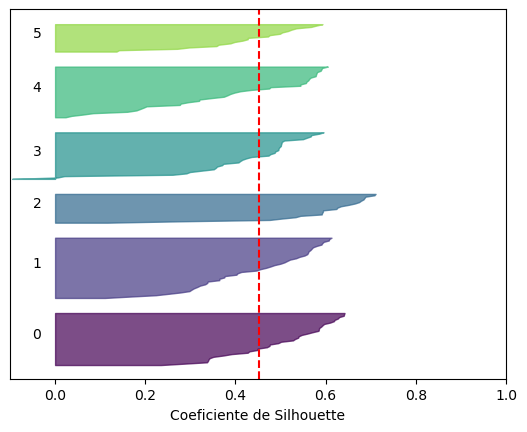

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples

def plot_silhouette(X, labels):
    # Calcular los valores de Silhouette para cada muestra
    silhouette_vals = silhouette_samples(X, labels)

    # Calcular el coeficiente de Silhouette medio
    silhouette_avg = np.mean(silhouette_vals)

    # Ordenar los valores de Silhouette para cada muestra
    sorted_silhouette_vals = np.sort(silhouette_vals)

    # Obtener el número de clusters
    num_clusters = len(np.unique(labels))

    # Configurar la figura y los ejes
    fig, ax = plt.subplots()

    # Configurar los límites de los ejes y el espacio entre los clusters
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (num_clusters + 1) * 10])

    # Calcular la altura de cada barra
    y_lower = 10

    for i in range(num_clusters):
        # Obtener los valores de Silhouette para el cluster actual
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        # Calcular el número de muestras en el cluster
        size_cluster_i = cluster_silhouette_vals.shape[0]

        # Calcular la parte superior y la inferior de la barra para el cluster actual
        y_upper = y_lower + size_cluster_i

        # Rellenar la barra de Silhouette para el cluster actual
        color = plt.cm.viridis(float(i) / num_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetar la barra con el número de cluster en el centro
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calcular la nueva posición para la siguiente barra
        y_lower = y_upper + 10

    # Dibujar una línea vertical en el coeficiente de Silhouette medio
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Etiquetar el eje y
    ax.set_yticks([])

    # Etiquetar el eje x
    ax.set_xlabel("Coeficiente de Silhouette")
    
    # Mostrar el gráfico
    plt.show()

# Utiliza esta función pasándole tus datos y las etiquetas de los clusters
plot_silhouette(datos_codificados, etiquetas_clusters)


**Análisis**

Para validar, se encuentra que los seis crusters del modelo superan la línea punteada roja, la cual representa el coeficiente de Silhouette medio para todos los datos. Y dado que todas las barras están por encima de ella, lo cual se interpreta como una señal positiva, se puede concluir que si hay una buena estructura de clustering.

---

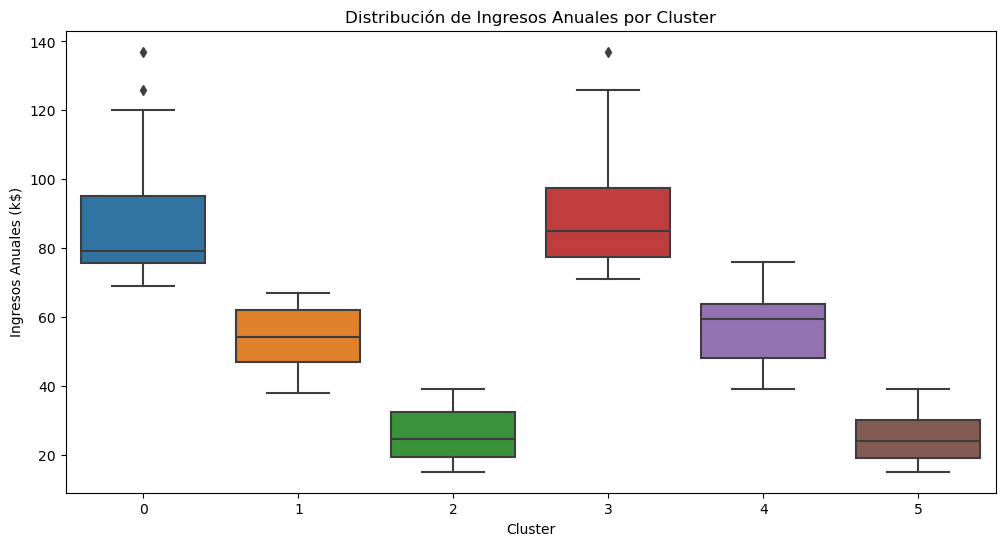

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot (Diagrama de Caja)
plt.figure(figsize=(12, 6))
sns.boxplot(x=etiquetas_clusters, y=datos_codificados['Annual Income (k$)'])
plt.title('Distribución de Ingresos Anuales por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ingresos Anuales (k$)')
plt.show()


**Análisis**
- Los clusters **0 y 3** tienen outliers (valores atípicos), indicando que hay individuos con ingresos significativamente más altos en esos grupos.
- Los clusters **1, 2 y 4** parecen tener una distribución más homogénea de ingresos, con menos variabilidad y sin valores atípicos evidentes.

---

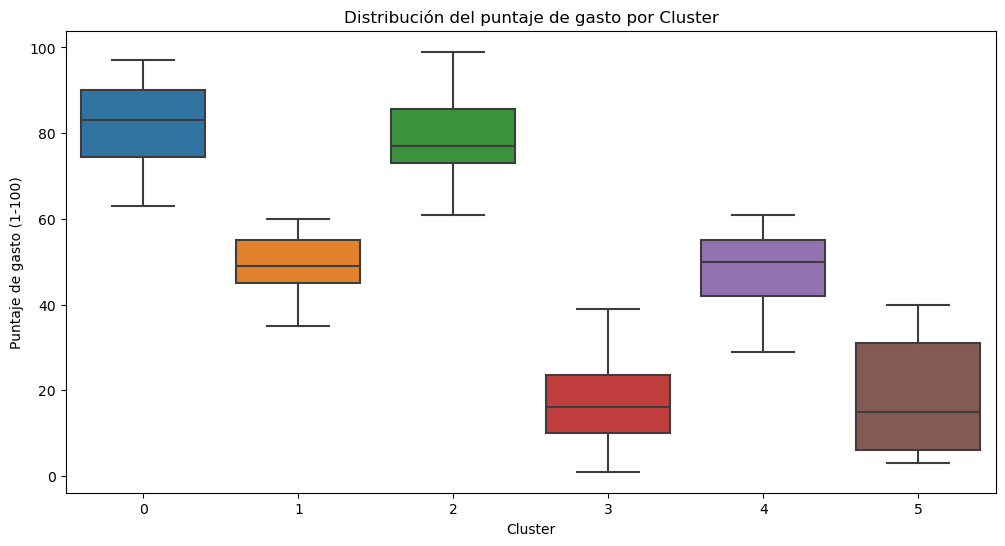

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot (Diagrama de Caja)
plt.figure(figsize=(12, 6))
sns.boxplot(x=etiquetas_clusters, y=datos_codificados['Spending Score (1-100)'])
plt.title('Distribución del puntaje de gasto por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Puntaje de gasto (1-100)')
plt.show()


**Análisis** 

Los clusters **0** y **2** muestran una alta puntuación media en gastos con menos variabilidad. Esto podría indicar que los clientes en estos grupos tienden a gastar consistentemente altas cantidades.

El cluster **3** tiene una baja puntuación media en gastos. Esto podría indicar que los clientes en este grupo tienden a gastar menos.

Los clusters **1**, **4**, y **5** están en un rango intermedio con variabilidades diversas. Esto podría indicar una mezcla de comportamientos de gasto en estos grupos.

**Conclusiones claves al comparar los gráficos _Distribución del puntaje de gasto por Cluster_ y _Distribución de Ingresos Anuales por Cluster_**

El cluster *2* es uno de los grupos con menos ingresos anuales y más puntaje de gasto, mientras que el cluster *3* tiene uno de los niveles de ingresos anuales más altos y uno de los puntajes de gasto más bajos. 

---

Un vistazo más profundo:

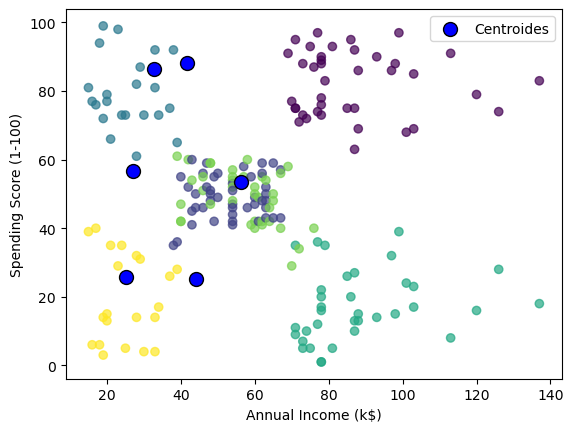

In [48]:
import matplotlib.pyplot as plt

# Trama los puntos de datos
plt.scatter(datos_codificados['Annual Income (k$)'], datos_codificados['Spending Score (1-100)'], c=etiquetas_clusters, cmap='viridis', alpha=0.7)

# Trama los centroides
plt.scatter(centroides[:, 1], centroides[:, 2], marker='o', s=100, c='blue', edgecolors='k', label='Centroides')

# Etiqueta los ejes
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

# Agrega una leyenda
plt.legend()

# Muestra el gráfico
plt.show()

**Análisis**

Esta gráfica muestra de una forma mejor definida diferentes patrones de gasto en relación con los ingresos anuales. Por ejemplo, hay dos grupos (clusters morado y verde) con ingresos medios a altos y una alta puntuación de gasto. Esto podría indicar que estos grupos tienden a gastar casi todos sus ingresos. Mientras que por otro lado, en el cluster azul cielo, el grupo tiende a ganar entre 70 y 100 mil dólares y manejar un margen más sensato de gasto.

---

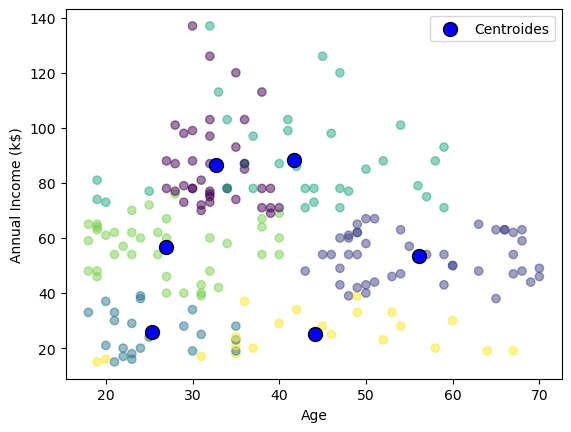

In [40]:
import matplotlib.pyplot as plt

# Trama los puntos de datos
plt.scatter(datos_codificados['Age'], datos_codificados['Annual Income (k$)'], c=etiquetas_clusters, cmap='viridis', alpha=0.5)

# Trama los centroides
plt.scatter(centroides[:, 1], centroides[:, 2], marker='o', s=100, c='blue', edgecolors='k', label='Centroides')

# Etiqueta los ejes
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')

# Agrega una leyenda
plt.legend()

# Muestra el gráfico
plt.show()


**Análisis**

El gráfico muestra la relación entre la “Edad” y los “Ingresos Anuales (k$)”. 

En el eje X, tenemos la edad que varía de 20 a 70 años. El eje Y representa los “Ingresos Anuales (k$)", que varían desde el valor mínimo de cero hasta el máximo valor posible que es 140 mil dólares. Los centroides indican los centros promedio de los clusters coloreados donde el cluster azul cielo es uno de los que presenta más dispersión entra la edad y los ingresos anuales.

----
----

**Conclusión** 

El modelo de K-means que se ha desarrollado, validado utilizando métricas como el coeficiente de Silhouette, ha demostrado un buen rendimiento. Esta validación nos brinda confianza en la calidad de los grupos identificados y nos permite extraer insights relevantes sobre las características distintivas de cada grupo, lo que proporciona una comprensión más profunda de nuestros datos y sus patrones subyacentes. 


---
---